<AxesSubplot:xlabel='DATE'>

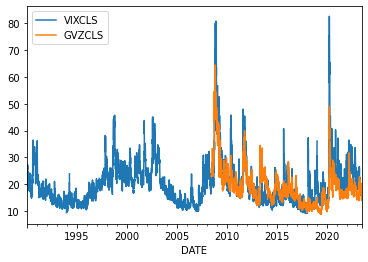

In [10]:
from pkg.src.core import data, Optimizer
import numpy as np

# prices = data.get_prices("SPY, AGG, BND, GLD, GSG, ACWI, XLY")
# specific_constraints = [
#     {"assets" : ["ACWI", "SPY"], "bounds" : {0.5, None}},
#     {"assets" : ["GLD"], "bounds" : {None, 0.10}},
# ]

# opt = Optimizer.from_prices(prices=prices, weight_bounds=(0.05, 1.0)).set_specific_constraints(
#     specific_constraints=specific_constraints
# )
# opt.hierarchical_equal_risk_contribution()

import pandas as pd
def get_vix() -> pd.DataFrame:
    return data.get_macro(tickers="VIXCLS, GVZCLS")

data = get_vix()

data.plot()

In [13]:
data["VIXCLS"].rolling(252).mean()

DATE
1990-01-02   NaN
1990-01-03   NaN
1990-01-04   NaN
1990-01-05   NaN
1990-01-08   NaN
              ..
2023-05-31   NaN
2023-06-01   NaN
2023-06-02   NaN
2023-06-05   NaN
2023-06-06   NaN
Freq: B, Name: VIXCLS, Length: 8721, dtype: float64

<AxesSubplot:xlabel='DATE'>

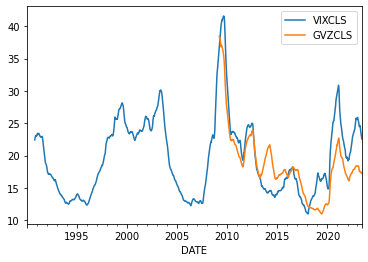

In [16]:
data.rolling(252, min_periods=200).mean().plot()

In [ ]:

import pandas as pd


def to_macd(
    prices: pd.DataFrame,
    fast_window: int = 12,
    slow_window: int = 26,
    signal_window: int = 9,
) -> pd.DataFrame:
    MACD = (
        + prices.ewm(span=fast_window, min_periods=fast_window).mean()
        - prices.ewm(span=slow_window, min_periods=slow_window).mean()
    )
    signal = MACD.ewm(span=signal_window, min_periods=slow_window).mean()
    
    return signal

to_macd(prices).loc["2022"].plot()

<AxesSubplot:xlabel='Date'>

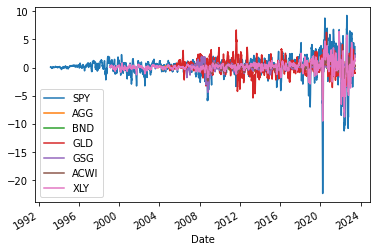

In [18]:
(
    prices.ewm(span=12, min_periods=12).mean()
    - prices.ewm(span=26, min_periods=26).mean()
).plot()


In [2]:
opt.constraints

[{'type': 'eq',
  'fun': <function pkg.src.core.portfolios.optimizer.Optimizer.set_sum_weight.<locals>.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.optimizer.Optimizer.set_min_weight.<locals>.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.optimizer.Optimizer.set_max_weight.<locals>.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.optimizer.Optimizer.set_min_return.<locals>.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.optimizer.Optimizer.set_max_return.<locals>.<lambda>(w)>}]

In [ ]:
yield_curve = {"T10Y2Y": "10Y-2Y", "T10Y3M": "10Y-3M"}

yield_curve_data = data.get_macro(list(yield_curve.keys())).loc["2019":]
yield_curve_data = yield_curve_data.rename(columns=yield_curve)
yield_curve_data.head().to_markdown()

In [ ]:
import plotly_express as px

px.line(yield_curve_data)


In [ ]:
my_list = [10, 20, 30, 40, 50]

# Get the index of a value in the list
value = 30

if value in my_list:
    index = my_list.index(value)
    print("Index of", value, "in the list:", index)
else:
    print(value, "is not present in the list.")

In [ ]:
from pkg.src.core.feature import PriceMomentum12M
from pkg.src.core import data

prices = data.get_prices("XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU")

factor = PriceMomentum12M(prices)

print(factor.standard_scalar)


In [1]:
from pkg.src.core import factors

factors.volatility_3m(tickers="SPY, AGG")

,SPY,AGG
Date,,
1993-02-01,NaN,NaN
1993-02-02,NaN,NaN
1993-02-03,NaN,NaN
1993-02-04,NaN,NaN
1993-02-05,NaN,NaN
...,...,...
2023-06-01,0.76025,0.23975
2023-06-02,0.76025,0.23975
2023-06-05,0.76025,0.23975


In [5]:
from pkg.src.core import data

data.get_universe()


,universe,ticker,name
0,GLOBALAA,SPY,U.S. Stocks (S&P500)
1,GLOBALAA,EZU,Europe Stocks (FTSE Europe)
2,GLOBALAA,VPL,Asia Pacific Stocks (MSCI Asic Pacific)
3,GLOBALAA,EEM,Emerging Market Stocks (MSCI Emerging)
4,GLOBALAA,RWR,Global REITs
5,GLOBALAA,GLD,Gold
6,GLOBALAA,GSG,Commodities
7,GLOBALAA,IEF,Intermediate Treasuries (7-10Y)
8,GLOBALAA,TLT,Long-Term Treasuries (20+Y)
9,GLOBALAA,EMB,Emerging Bond (USD)


XLY    0.111111
XLP    0.000000
XLE   -0.000000
XLF    0.532041
XLV    0.110682
XLI    0.072178
XLB    0.110873
XLK    0.063115
XLU    0.000000
Name: weights, dtype: float64
XLY    0.111111
XLP    0.111108
XLE    0.000000
XLF    0.530444
XLV    0.111111
XLI    0.111091
XLB    0.000000
XLK    0.025135
XLU    0.000000
Name: weights, dtype: float64
XLY    0.111123
XLP    0.111125
XLE    0.000000
XLF    0.111120
XLV    0.533804
XLI    0.111114
XLB   -0.000000
XLK    0.000000
XLU    0.021714
Name: weights, dtype: float64
XLY    0.111119
XLP    0.111111
XLE    0.000000
XLF    0.111110
XLV    0.511033
XLI    0.044516
XLB    0.000000
XLK    0.000000
XLU    0.111111
Name: weights, dtype: float64
XLY    0.111110
XLP    0.111115
XLE    0.000000
XLF    0.111111
XLV    0.498828
XLI    0.056734
XLB    0.000000
XLK   -0.000000
XLU    0.111102
Name: weights, dtype: float64
XLY    0.111109
XLP    0.033432
XLE    0.111120
XLF    0.522016
XLV    0.111213
XLI    0.111111
XLB    0.000000
XLK    0.000000
XL

<AxesSubplot:>

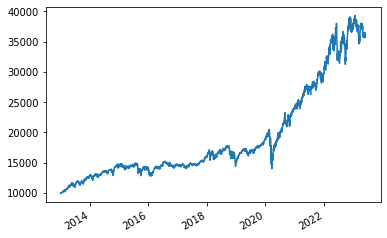

In [1]:
from pkg.src.core.metrics.rolling import to_momentum
from pkg.src.core import data
from pkg.src.core.strategies import BacktestManager
import pandas as pd
from scipy.stats import norm


def to_standard_scalar(features: pd.Series) -> pd.Series:
    scalar = (features - features.mean()) / features.std()
    return scalar


def to_standard_percentile(features: pd.Series) -> pd.Series:
    return to_standard_scalar(features=features).aggregate(norm.cdf)


prices = data.get_prices("XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU")

bt = BacktestManager(prices=prices)
features = to_momentum(prices=prices, months=12).apply(to_standard_percentile, axis=1)

bt.Base(name="Strategy1", start="2013-1-1", features=features, percentile=0.8)
#
bt.strategies["Strategy1"].allocations
# features
bt.strategies["Strategy1"].value.plot()

In [2]:
from pkg.src.core import feature

functions = [func for func in dir(feature) if callable(getattr(feature, func))]
functions


['price_momentum_12m',
 'price_momentum_12m_1m',
 'price_momentum_12m_2m',
 'price_momentum_1m',
 'price_momentum_24m',
 'price_momentum_24m_1m',
 'price_momentum_24m_2m',
 'price_momentum_36m',
 'price_momentum_36m_1m',
 'price_momentum_36m_2m',
 'price_momentum_3m',
 'price_momentum_6m',
 'price_momentum_6m_1m',
 'price_momentum_6m_2m']

In [6]:
pri_momentum = data.price_momentum_1m(tickers="SPY, AGG")
pri_momentum

,SPY,AGG
Date,,
1993-01-29,NaN,NaN
1993-02-01,NaN,NaN
1993-02-02,NaN,NaN
1993-02-03,NaN,NaN
1993-02-04,NaN,NaN
...,...,...
2023-05-26,0.76025,0.23975
2023-05-30,0.76025,0.23975
2023-05-31,0.76025,0.23975


In [ ]:
import json

# from core.signals import OECDUSLEIHP
from pkg.core.strategies import BacktestManager

# signal = OECDUSLEIHP.from_fred_data()


def get_universe(name: str = "USSECTOR"):
    with open("universe.json") as f:
        return json.load(f).get(name)


from pkg.src.core import data

prices = data.get_prices(tickers=list(get_universe().keys()))
bt = BacktestManager(prices=prices, start="2007-1-1", commission=10, shares_frac=0)
# bt.Momentum(target_percentile=0.7, months=3)
# bt.values.plot(figsize=(12, 10))
# bt.analytics

from core import metrics

metrics.to_momentum(prices=prices.iloc[:, 0], months=12, skip_months=1)

In [1]:
from pkg.src.core import data


data.get_universe()


{'GLOBALAA': {'SPY': 'U.S. Stocks (S&P500)',
  'EZU': 'Europe Stocks (FTSE Europe)',
  'VPL': 'Asia Pacific Stocks (MSCI Asic Pacific)',
  'EEM': 'Emerging Market Stocks (MSCI Emerging)',
  'RWR': 'Global REITs',
  'GLD': 'Gold',
  'GSG': 'Commodities',
  'IEF': 'Intermediate Treasuries (7-10Y)',
  'TLT': 'Long-Term Treasuries (20+Y)',
  'EMB': 'Emerging Bond (USD)',
  'IGOV': 'International Treasury',
  'TIP': 'Long-Term Inflation Hedged'},
 'USSECTOR': {'XLC': 'Communication Services Select Sector SPDR Fund',
  'XLY': 'Consumer Discretionary Select Sector SPDR Fund',
  'XLP': 'Consumer Staples Select Sector SPDR Fund',
  'XLE': 'Energy Select Sector SPDR Fund',
  'XLF': 'Financial Select Sector SPDR Fund',
  'XLV': 'Health Care Select Sector SPDR Fund',
  'XLI': 'Industrial Select Sector SPDR Fund',
  'XLB': 'Materials Select Sector SPDR Fund',
  'XLRE': 'Real Estate Select Sector SPDR Fund',
  'XLK': 'Technology Select Sector SPDR Fund',
  'XLU': 'Utilities Select Sector SPDR Fund'}

In [ ]:
opt = Optimizer.from_prices(prices=prices.loc["2017"].dropna(axis=1))

w = opt.hierarchical_risk_parity()

w


In [ ]:
from pkg.src.core.portfolios import objectives

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[8],
    )
)

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[0, 3],
    )
)

In [ ]:
objectives.expected_volatility(w, opt.covariance_matrix)

In [ ]:
dist = np.sqrt((1 - opt.correlation_matrix).round(5) / 2)
clusters = linkage(squareform(dist), method="single")
sorted_tree = list(to_tree(clusters, rd=False).pre_order())

print(sorted_tree)


def recursive_bisection(sorted_tree):
    """_summary_

    Args:
        sorted_tree (_type_): _description_

    Returns:
        List[Tuple[List[int], List[int]]]: _description_
    """

    left = sorted_tree[0 : int(len(sorted_tree) / 2)]
    right = sorted_tree[int(len(sorted_tree) / 2) :]

    if len(sorted_tree) < 3:
        return (left, right)

    cache = [(left, right)]
    if len(left) > 2:
        cache.extend(recursive_bisection(left))
    if len(right) > 2:
        cache.extend(recursive_bisection(right))
    return cache


cluster_sets = recursive_bisection(sorted_tree)

for i in cluster_sets:
    print(i)

In [ ]:
from core import data
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = {
    "T5YIE": "Breakeven Inflation: 5Y",
    "T10YIE": "Breakeven Inflation: 10Y",
    "T5YIFR": "Expectation Infaltiona: 5Y",
}

result = data.get_macro(tickers=tickers).dropna()
result["chg"] = result["Breakeven Inflation: 10Y"] - result["Breakeven Inflation: 5Y"]
spy = data.get_prices(tickers="SPY")

# Create a line plot for each series
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(
    go.Scatter(x=spy.index, y=spy["SPY"], mode="lines", name="SPY"), row=1, col=1
)
for series in result:
    fig.add_trace(
        go.Scatter(x=result.index, y=result[series], mode="lines", name=series),
        row=2,
        col=1,
    )

# Set the title and axis labels
fig.update_layout(title="Inflation", xaxis_title="Date", yaxis_title="%", height=600)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=False),
        type="date",
    ),
    hovermode="x unified",  # Enable the "Show All Stats" option on mouseover
)

# Display the graph
fig.show()


In [ ]:
from core.strategies import BacktestManager

bt = BacktestManager.from_universe(start="2010-1-1", commission=10, shares_frac=0)
bt.Momentum()
bt.values.plot()